# Exploration of DNS-over-HTTPS Traffic Dataset

The purpose of this notebook is to visualize the charactersitics of the DNS-over-HTTPS (DoH) dataset. We will calculate and visualize multiple aspects of the data to gain insights and a deeper understanding of its underlying patterns. In order to achieve this, we will use standard data exploration techniques and try to create a variety of plots, including correlations, scatter plots, and histograms.

## Data Preparation
We start by loading two existing datasets of statistical features of TCP connections carrying DoH traffic into a Pandas dataframe. One dataset contains normal traffic and the other one malicious traffic. 

The datasets are in CSV format with a column for each feature. The Pandas dataframe allows us to read the CSV file into a Python data structure that is very similar to an Excel sheet. 

In [1]:
# The file that contains the normal DoH traffic data. In this case, we are using the traffic generated 
# using the Cloudflare dataset.
normal_doh_traffic_dataset = '../doh_traffic_datasets/normal_doh_traffic_cloudflare_server.csv'

# The file that contains the malicious DoH traffic. We are using DoH traffic that carries a dnscat 
# tunnel for data exfiltration. 
malicious_doh_traffic_dataset = '../doh_traffic_datasets/dnscat2_data_4.csv'

# Import the pandas library
import pandas as pd

# Load the datasets into Pandas dataframes
normal_traffic_df    = pd.read_csv(normal_doh_traffic_dataset)
malicious_traffic_df = pd.read_csv(malicious_doh_traffic_dataset)

### Lets see what we have in the dataframes

In [2]:
normal_traffic_df

,bytes_out,num_pkts_out,bytes_in,num_pkts_in,bytes_ration,num_pkts_ration,time,av_pkt_size_in,av_pkt_size_out,var_pkt_size_in,var_pkt_size_out,median_in,median_out,mindelay,avgdelay,maxdelay,is_doh
0,0.038207,0.040566,0.037993,0.042252,0.330945,0.666667,0.142261,0.161100,0.446486,0.029621,0.089444,0.271106,0.446486,0.0,0.156132,0.138663,1
1,0.158368,0.164492,0.157195,0.165296,0.330548,0.643651,0.368210,0.179073,0.482115,0.031426,0.088050,0.286723,0.482115,0.0,0.101448,0.138796,1
2,0.444930,0.461775,0.413861,0.452236,0.309801,0.627386,0.999888,0.166632,0.483418,0.026398,0.095197,0.275913,0.483418,0.0,0.099373,0.138832,1
3,0.132261,0.153362,0.135935,0.157628,0.342253,0.658327,0.999999,0.148324,0.312008,0.036691,0.085530,0.260006,0.312008,0.0,0.292235,0.193173,1
4,0.129911,0.151098,0.133228,0.155072,0.341502,0.657356,0.999391,0.147198,0.307559,0.035029,0.083906,0.259027,0.307559,0.0,0.296651,0.138849,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2345,0.245127,0.262281,0.246135,0.271685,0.334409,0.663545,0.999645,0.163445,0.434373,0.035066,0.089048,0.273144,0.434373,0.0,0.170155,0.272727,1
2346,0.300659,0.314975,0.313175,0.327676,0.346911,0.666423,0.999829,0.180722,0.468194,0.035075,0.090260,0.288155,0.468194,0.0,0.141410,0.272718,1
2347,0.140337,0.164377,0.128410,0.162061,0.304705,0.631497,0.999655,0.124026,0.297336,0.026048,0.078014,0.238894,0.297336,0.0,0.278195,0.138841,1
2348,0.089373,0.111913,0.078803,0.116054,0.293583,0.664153,0.999880,0.084697,0.203864,0.020469,0.071056,0.204722,0.203864,0.0,0.398651,0.272718,1


In [3]:
malicious_traffic_df

,bytes_out,num_pkts_out,bytes_in,num_pkts_in,bytes_ration,num_pkts_ration,time,av_pkt_size_in,av_pkt_size_out,var_pkt_size_in,var_pkt_size_out,median_in,median_out,mindelay,avgdelay,maxdelay,is_doh
0,0.008161,0.007220,0.005402,0.004601,0.015788,0.472420,0.109359,0.014784,0.219169,0.000845,0.043973,0.024431,0.219169,0.0,0.025787,0.133319,4
1,0.007925,0.007001,0.005310,0.004494,0.015971,0.475742,0.108966,0.014937,0.219992,0.001648,0.042766,0.024583,0.219992,0.0,0.026402,0.133434,4
2,0.007927,0.007001,0.005307,0.004494,0.015957,0.475742,0.108686,0.014924,0.220146,0.001648,0.042823,0.024570,0.220146,0.0,0.026335,0.133194,4
3,0.033504,0.029209,0.030564,0.018976,0.022046,0.484338,0.109759,0.023958,0.222640,0.000929,0.040278,0.033516,0.222640,0.0,0.006337,0.133176,4
4,0.052905,0.046056,0.049718,0.029998,0.022747,0.485913,0.109686,0.024939,0.222903,0.000833,0.039963,0.034487,0.222903,0.0,0.004011,0.135245,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10293,0.004841,0.003884,0.004026,0.002390,0.019600,0.453245,0.244249,0.025513,0.271441,0.003665,0.101614,0.035055,0.271441,0.0,0.108927,0.134632,4
10294,0.004591,0.003774,0.004010,0.002354,0.020557,0.459236,0.244362,0.025910,0.259148,0.003712,0.099855,0.035449,0.259148,0.0,0.111400,0.134135,4
10295,0.486491,0.485395,0.618845,0.440414,0.030865,0.677616,0.818411,0.019639,0.160669,0.000732,0.038659,0.029239,0.160669,0.0,0.002374,0.008762,4
10296,0.005056,0.005360,0.003792,0.003424,0.017697,0.472309,0.511998,0.013381,0.142958,0.001235,0.079285,0.023042,0.142958,0.0,0.162424,0.133958,4


### The contents of the dataset

We see that the normal and malicious datasets have 17 columns. These columns are statistical features of the TCP connections related to round trip times, number of bytes, number of packets, etc. We explain what these columns mean later in this notebook.

The is_doh column indicates the type of traffic. We have 1 for normal traffic and number higher than 1 for malicious traffic.  

## Preparing the datasets

The first step is to prepare a dataset the contains both benign and malicious data. The percentage of malicious data is set to 30%. Depending on the model, we will need both malicious and bening data for training or only benign.  

In [27]:
# We get a random set of malicious samples based on the contamination percentage.
contamination              = 0.3
seed                       = 1  
num_malicious              = min(malicious_traffic_df.shape[0], int(normal_traffic_df.shape[0]*contamination))
data_exploration_malicious  = malicious_traffic_df.sample(num_malicious, random_state=seed)


# Concatenate the normal testing data and the malicious data to
# create the evaluation data set
data_exploration_df = pd.concat([normal_traffic_df, data_exploration_malicious])


# Shuffle the malicious samples in the whole dataset. 
data_exploration_df = data_exploration_df.sample(data_exploration_df.shape[0], random_state=1)



## Label standarization

To make things easier for our models, we set the labels for normal traffic to 1 and for malicious traffic to -1. The original labels for malicious traffic are 4's. 

In [30]:
# Standarize labels. If the labels are greater than 1, it means the traffic is malicious. We set those samples to -1
# as required by the ML Python libraries. 
normal_traffic_label = 1
label_col            = 'is_doh'
data_exploration_df[label_col][data_exploration_df[label_col]>normal_traffic_label] = -1

# Repeat for malicioius data
malicious_traffic_df[label_col][malicious_traffic_df[label_col]>normal_traffic_label] = -1

# normal_traffic_df already is labeled correctly, i.e., all entries are legitimate and labeled as zero. 

# We save the dataframes for later
malicious_traffic_df.to_csv('data_malicious.csv', index=False)
normal_traffic_df.to_csv('data_normal.csv', index=False)

# Ignore warning


/tmp/ipykernel_179632/105777485.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data_exploration_df[label_col][data_exploration_df[label_col]>normal_traffic_label] = -1
/tmp/ipykernel_179632/105777485.py:5: SettingWithCopyWarning: 
A val

## Save the datasets
Finally, we save the training and testing datasets. 

In [26]:
# Ignore warning above

# Save dataset for later
data_exploration_df.to_csv('data_evaluation.csv', index=False)

# We create training and testing data sets for the ML models too
from sklearn.model_selection import train_test_split
data_training, data_testing = train_test_split(data_exploration_df, random_state=42)
data_training.to_csv('data_training.csv', index=False)
data_testing.to_csv('data_testing.csv', index=False)

,bytes_out,num_pkts_out,bytes_in,num_pkts_in,bytes_ration,num_pkts_ration,time,av_pkt_size_in,av_pkt_size_out,var_pkt_size_in,var_pkt_size_out,median_in,median_out,mindelay,avgdelay,maxdelay,is_doh
9061,0.029008,0.025544,0.031486,0.016586,0.026214,0.483947,0.293213,0.030003,0.218007,0.001675,0.040839,0.039502,0.218007,0.0,0.019362,0.134419,-1
2687,0.004659,0.003884,0.004058,0.002461,0.020509,0.466774,0.244402,0.024763,0.251941,0.002307,0.098246,0.034312,0.251941,0.0,0.107439,0.133860,-1
8482,0.008010,0.007056,0.005285,0.004459,0.015732,0.468336,0.108786,0.015022,0.221342,0.001659,0.042624,0.024667,0.221342,0.0,0.026359,0.133327,-1
8417,0.004588,0.003774,0.004011,0.002354,0.020569,0.459236,0.244288,0.025912,0.258864,0.003712,0.099595,0.035451,0.258864,0.0,0.111366,0.134748,-1
7022,0.004591,0.003774,0.003987,0.002319,0.020434,0.452278,0.244395,0.026248,0.259205,0.003757,0.099863,0.035784,0.259205,0.0,0.112246,0.133887,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3088,0.012276,0.011870,0.011377,0.013412,0.022232,0.840082,0.364326,0.007937,0.177142,0.000613,0.029395,0.017652,0.177142,0.0,0.037811,0.134233,-1
9968,0.077934,0.072749,0.087668,0.086749,0.027252,0.889971,0.349166,0.011348,0.190101,0.000367,0.027716,0.021029,0.190101,0.0,0.005712,0.134091,-1
2711,0.004588,0.003774,0.004004,0.002354,0.020534,0.459236,0.245430,0.025851,0.258864,0.003710,0.099595,0.035390,0.258864,0.0,0.111887,0.133860,-1
6071,0.012233,0.011760,0.011279,0.013305,0.022118,0.841096,0.364449,0.007926,0.179651,0.000616,0.029584,0.017641,0.179651,0.0,0.038145,0.134517,-1


### The contents of the dataset

We see that the normal and malicious datasets have 16 columns labeled 0 to 15. These columns are statistical features of the TCP connections related to round trip times, number of bytes, number of packets, etc. We explain what these columns mean in notebook 0.

The is_doh column indicates the type of traffic. We have 1 for normal traffic and number higher than 1 for malicious traffic.  

## Correlation Matrix
One of the initial steps in our analysis will involve creating a correlation matrix to assess the relationships between numerical variables in the dataset. This matrix will be visualized as a heatmap, making it east to identify strong correlations, which can be crucial in feature selection for machine learning models.  

<function matplotlib.pyplot.show(close=None, block=None)>

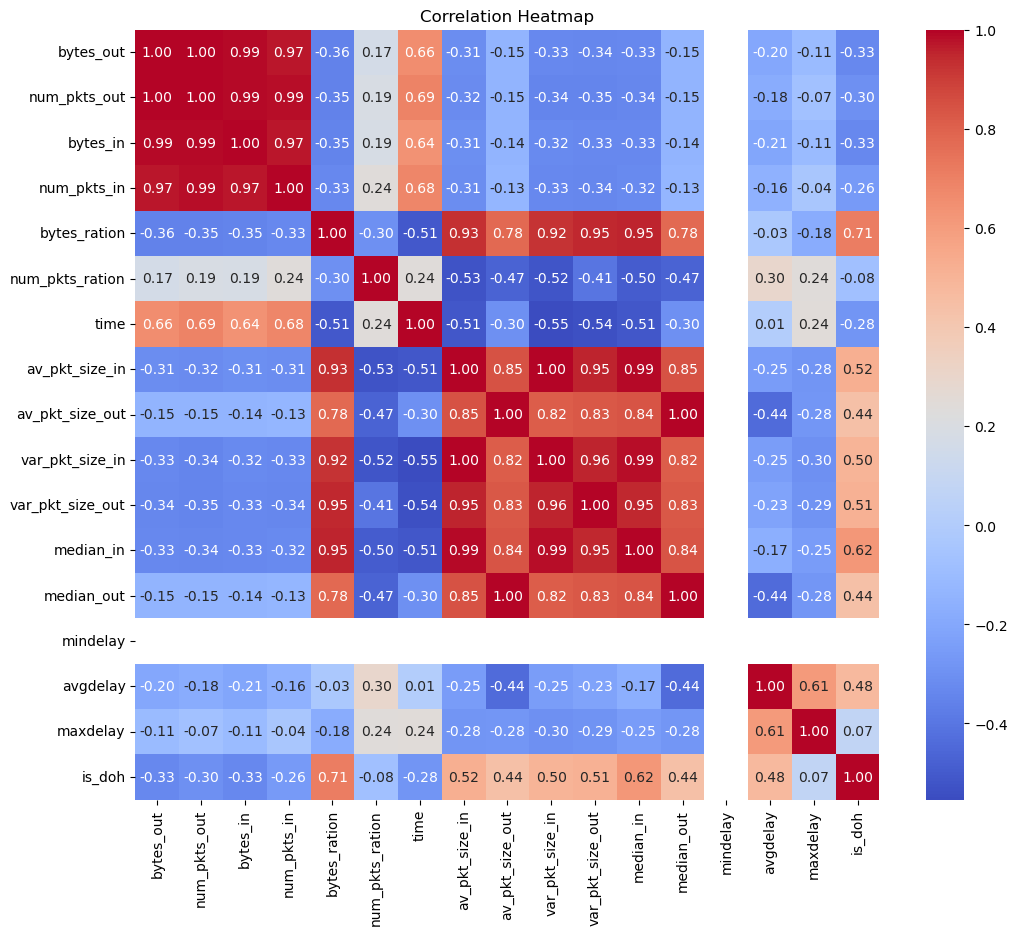

In [20]:
# Import the plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# We take a random sample of the trainig data set for visualization
data_vis = data_exploration_df.sample(n = 700)

# We use a small number of samples for visualization (i.e., 700) to decrease the processing time. But a
# more accurate representation can be obtained by increasing the number of samples. 

# Calculate the correlations and save in new variable.
correlation_matrix = data_vis.corr()

# Create a figure
plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')

# Show figure
plt.show

##  Data Cleaning: Drop the mindelay row and column from the correlation matrix? 

We see that the mindelay column only contains zeros. This column will not be useful for our models since
it provides information on how to distinguish a legitimate traffic flow from a malicious one (i.e., they
all look the same from the mindelay perspective. )

Removing irrelevant column is part of data cleaning. 

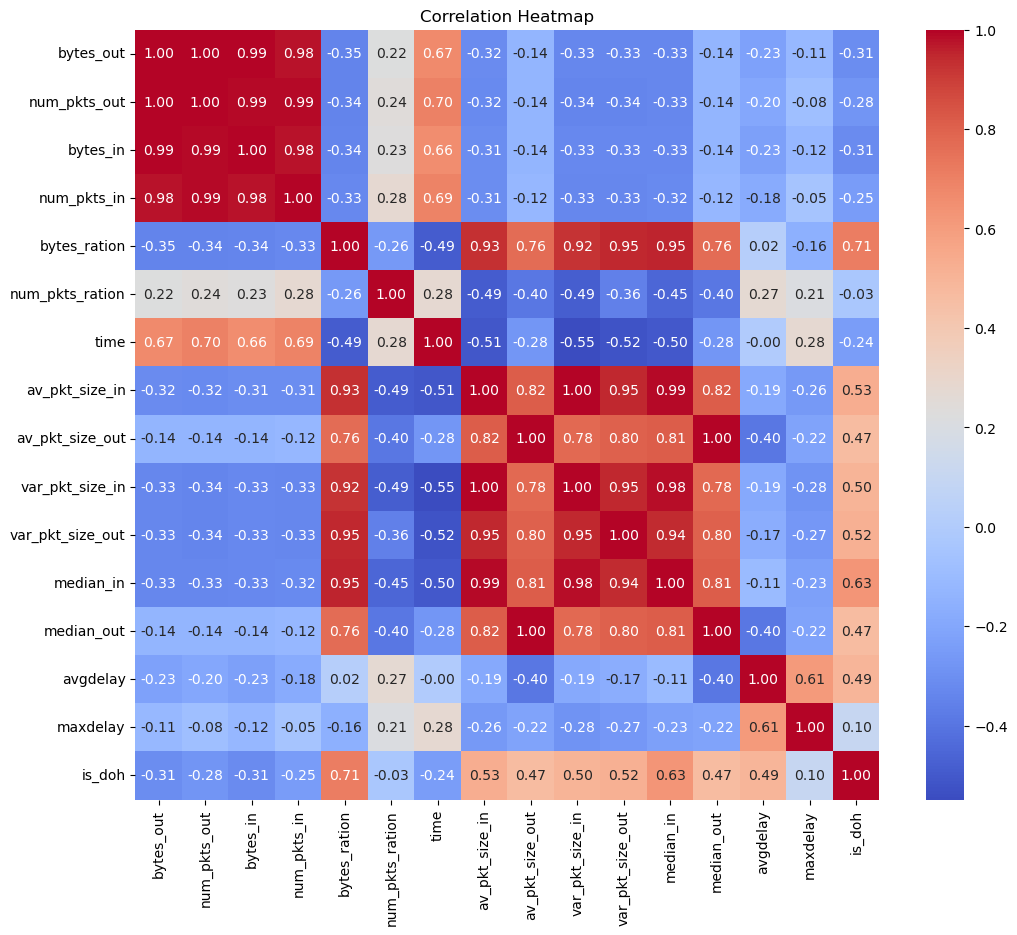

In [8]:
# Enter the row and column name that should be dropped
correlation_matrix = correlation_matrix.drop(index='mindelay',columns='mindelay')

# recreate the figure
plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')

# Show figure
plt.show()

## Pair Plots
Pair plots provide an efficient way to visualize multiple pairwise relationships at once. By plotting all combinations of numerical values, we can uncover potential patterns and dependencies within the data.

## Scatter Plots and Historgrams
Scatter plots will be useful for visualizing relationships between pairs of numerical variables. By creating scatter plots, we can explore how two variables interact with eachother. This can help us identify patterns, clusters, or trends within the data.The scatter plots are in the off-diagonal of the plot matrices. Their coordinate is given by the two features that are used for the plot. 

Historgrams help us to understand the distribution of individual numerical variables. These histograms will allow us to assess the central tendency and spread of each variable and help in identifying potential outliers. The histograms are in the diagonal of the plot matrices. 

/tmp/ipykernel_179632/2720840623.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data_vis[label_col][data_vis[label_col] == -1] = "malicious"
/tmp/ipykernel_179632/2720840623.py:2: SettingWithCopyWarning: 
A value is trying to be set on 

<function matplotlib.pyplot.show(close=None, block=None)>

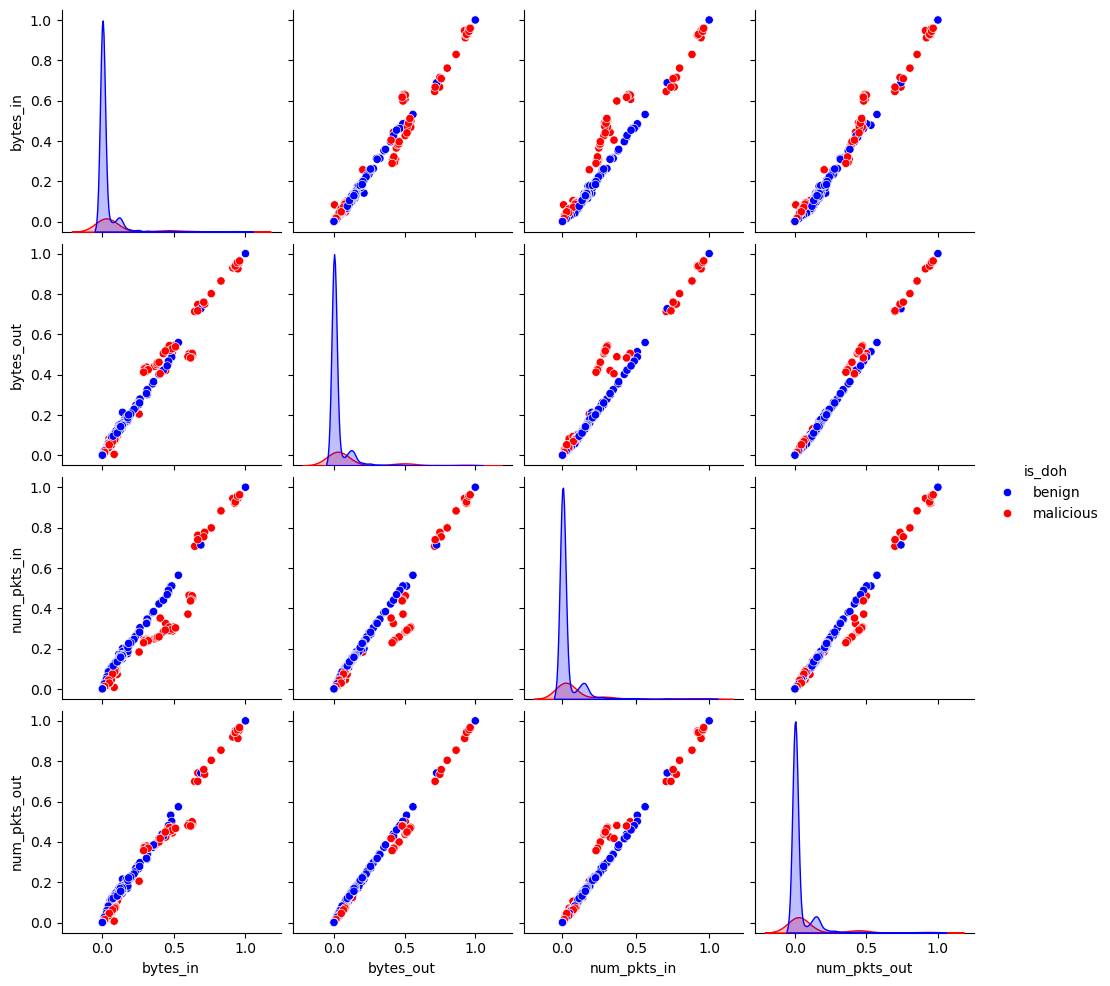

In [21]:
# Assign labels "malicious" and "benign" based on values in 'label_col'
data_vis[label_col][data_vis[label_col] == -1] = "malicious"
data_vis[label_col][data_vis[label_col] == 1] = "benign"

# Define a subset of variables for the pair plot
subset1 = ['bytes_in', 'bytes_out', 'num_pkts_in', 'num_pkts_out']

# Create a pair plot with specified attributes
sns.pairplot(data_vis, vars= subset1, diag_kind='kde', hue=label_col, palette= {'malicious':'red','benign':'blue' })

# Display the pair plot. Ignore warning
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

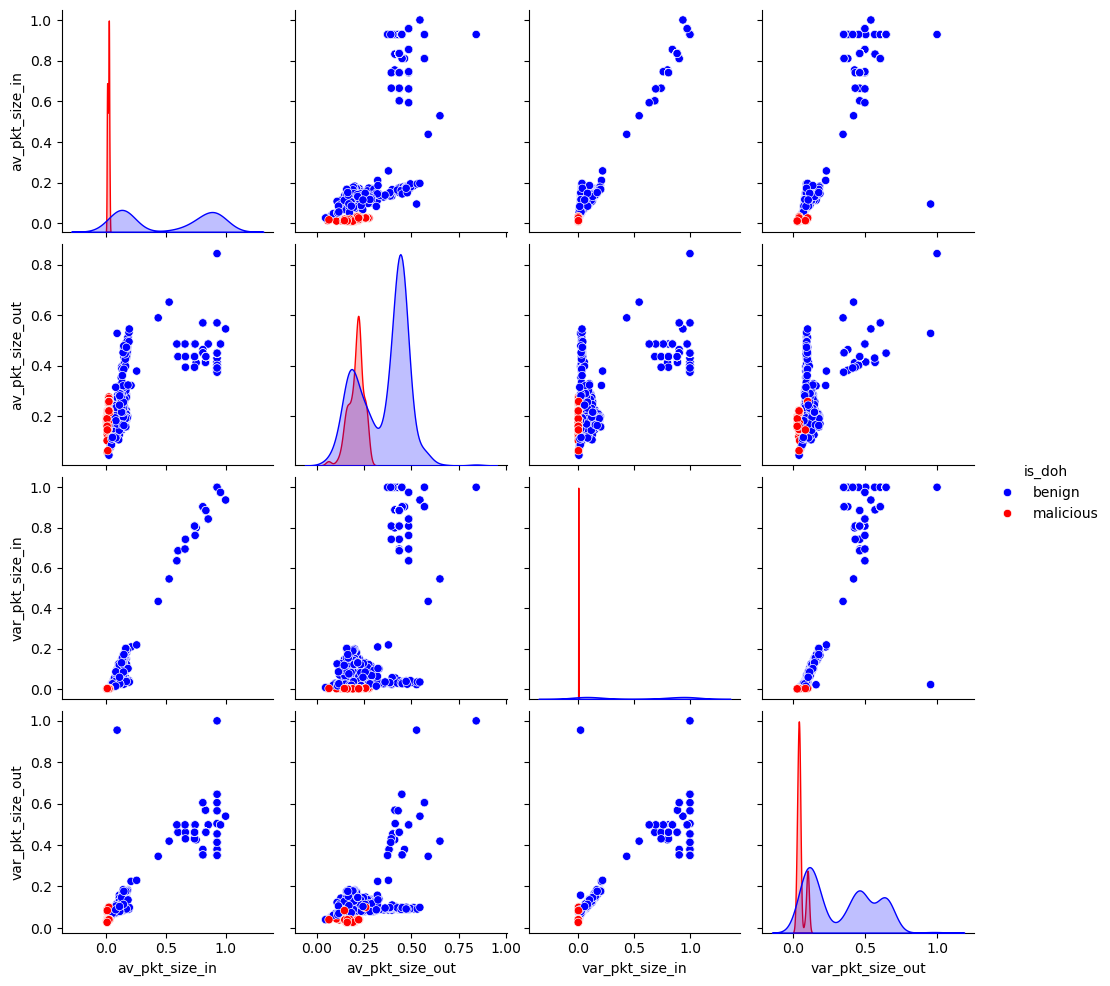

In [10]:
# Assign labels "malicious" and "benign" based on values in 'label_col'
data_vis[label_col][data_vis[label_col] == -1] = "malicious"
data_vis[label_col][data_vis[label_col] == 1] = "benign"

# Define a subset of variables for the pair plot
subset2 = ['av_pkt_size_in','av_pkt_size_out', 'var_pkt_size_in', 'var_pkt_size_out']

# Create a pair plot with specified attributes
sns.pairplot(data_vis, vars= subset2, diag_kind='kde', hue=label_col, palette= {'malicious':'red','benign':'blue' })

# Display the pair plot
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

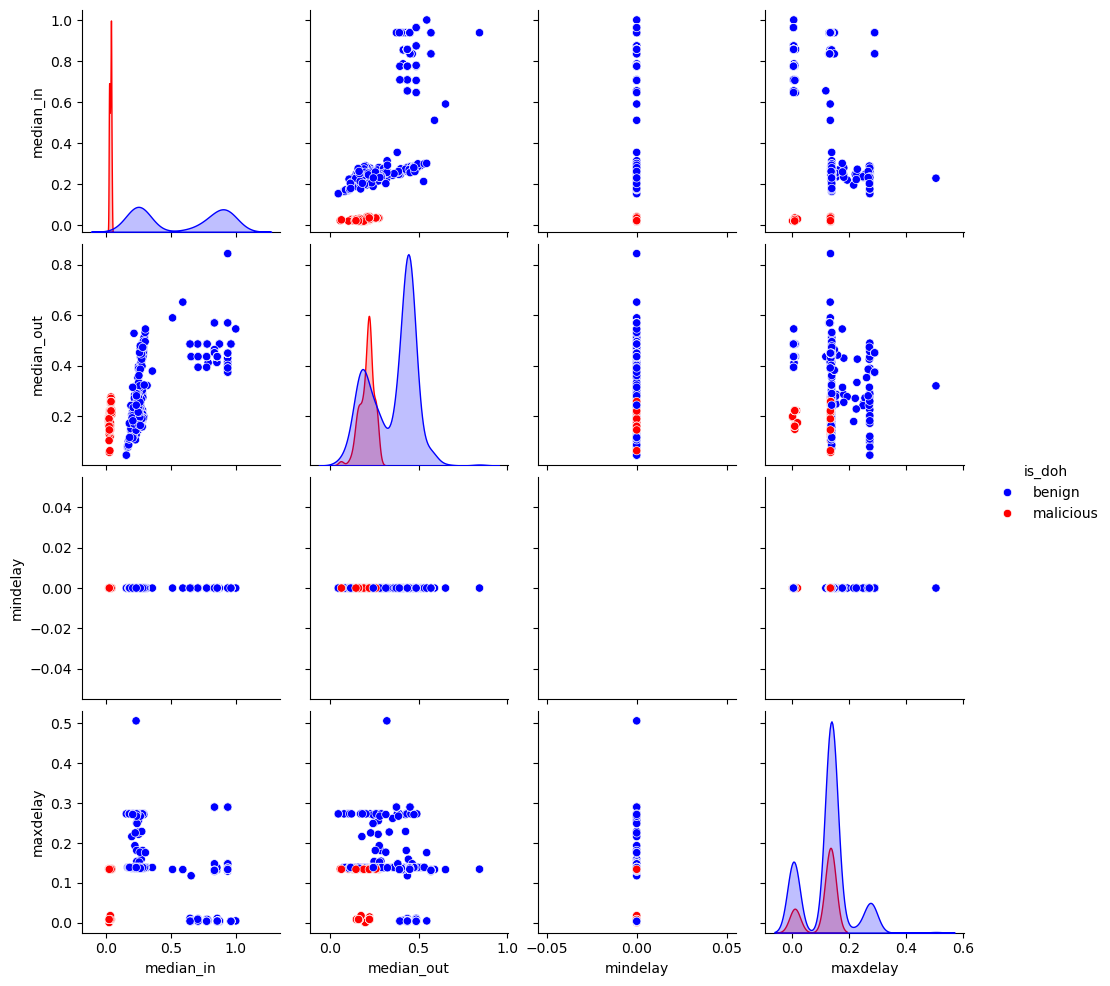

In [11]:
# Assign labels "malicious" and "benign" based on values in 'label_col'
data_vis[label_col][data_vis[label_col] == -1] = "malicious"
data_vis[label_col][data_vis[label_col] == 1] = "benign"

# Define a subset of variables for the pair plot
subset3 = ['median_in', 'median_out', 'mindelay', 'maxdelay']

# Create a pair plot with specified attributes
sns.pairplot(data_vis, vars= subset3, diag_kind='kde', hue=label_col, palette= {'malicious':'red','benign':'blue' })

# Display the pair plot
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

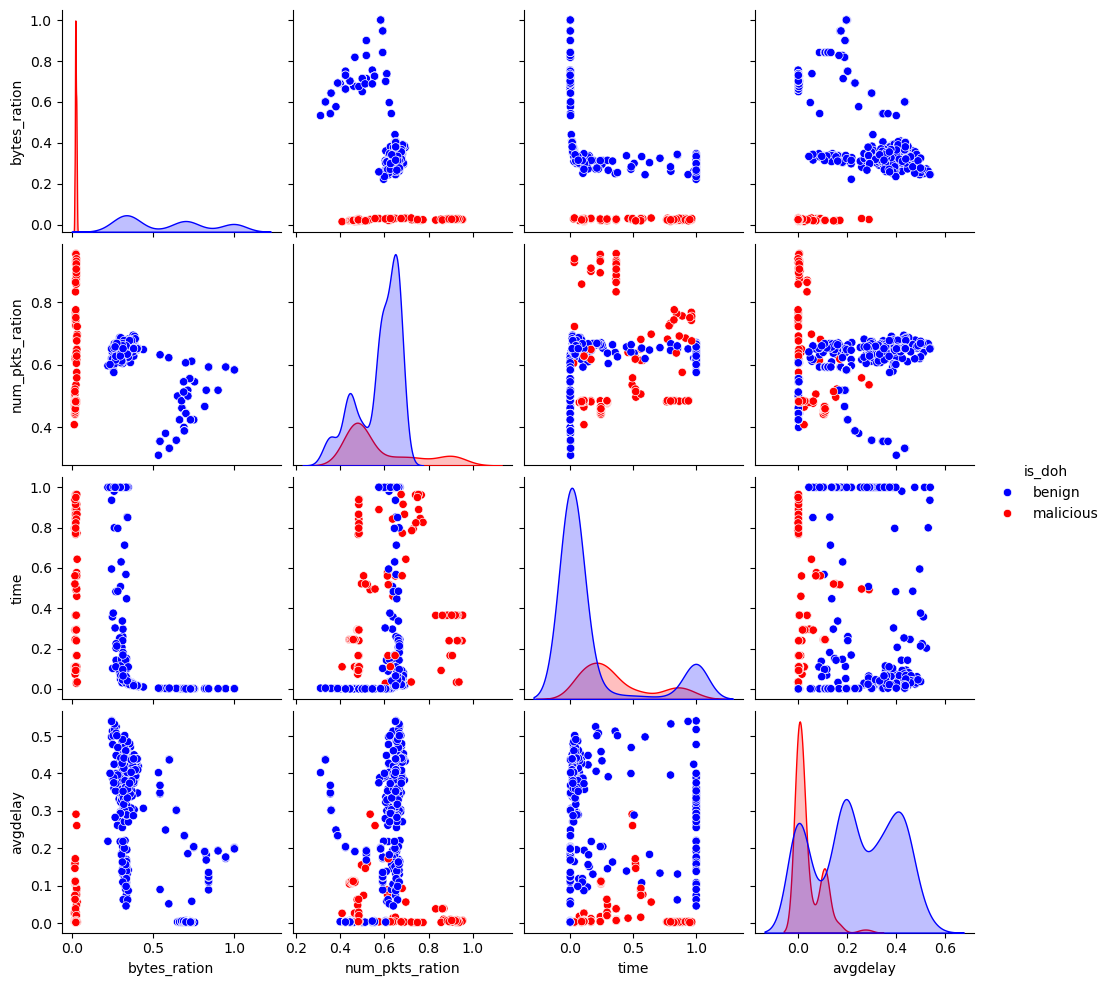

In [12]:
# Assign labels "malicious" and "benign" based on values in 'label_col'
data_vis[label_col][data_vis[label_col] == -1] = "malicious"
data_vis[label_col][data_vis[label_col] == 1] = "benign"

# Define a subset of variables for the pair plot
subset4 = ['bytes_ration', 'num_pkts_ration', 'time', 'avgdelay']

# Create a pair plot with specified attributes
sns.pairplot(data_vis, vars= subset4, diag_kind='kde', hue=label_col, palette= {'malicious':'red','benign':'blue' })

# Display the pair plot
plt.show

## Examples of scatter plots of one feature vs another feature

<function matplotlib.pyplot.show(close=None, block=None)>

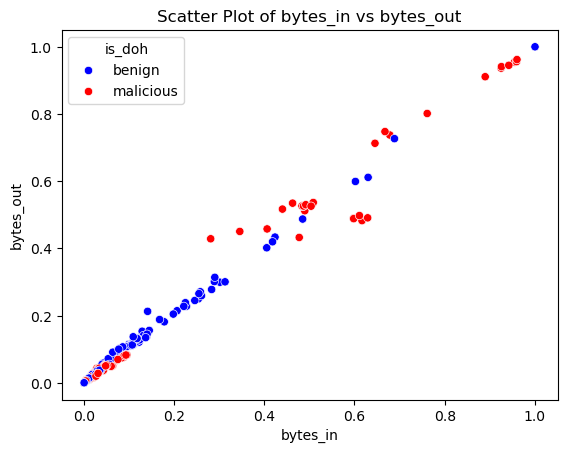

In [13]:
# Assign labels "malicious" and "benign" based on values in 'label_col'
data_vis[label_col][data_vis[label_col] == -1] = "malicious"
data_vis[label_col][data_vis[label_col] == 1] = "benign"

# Create a scatter plot with specified attributes
sns.scatterplot(x='bytes_in', y='bytes_out', data=data_vis, marker='o', hue=label_col,palette= {'malicious':'red','benign':'blue' })

# Set labels for the x and y axes
plt.xlabel('bytes_in')
plt.ylabel('bytes_out')

# Set the title for the scatter plot
plt.title('Scatter Plot of bytes_in vs bytes_out')

# Display the plot
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

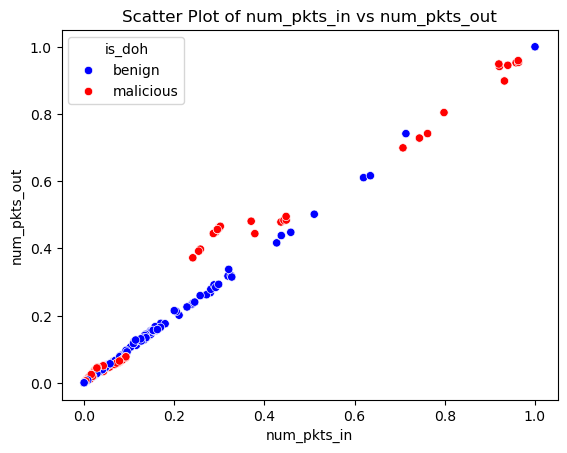

In [14]:
# Assign labels "malicious" and "benign" based on values in 'label_col'
data_vis[label_col][data_vis[label_col] == -1] = "malicious"
data_vis[label_col][data_vis[label_col] == 1] = "benign"

# Create a scatter plot with specified attributes
sns.scatterplot(x='num_pkts_in', y='num_pkts_out', data=data_vis, marker='o', hue=label_col, palette= {'malicious':'red','benign':'blue' })

# Set labels for the x and y axes
plt.xlabel('num_pkts_in')
plt.ylabel('num_pkts_out')

# Set the title for the scatter plot
plt.title('Scatter Plot of num_pkts_in vs num_pkts_out')

# Display the plot
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

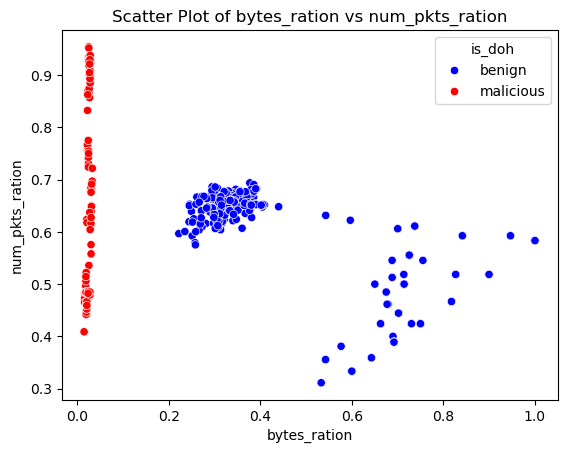

In [15]:
# Assign labels "malicious" and "benign" based on values in 'label_col'
data_vis[label_col][data_vis[label_col] == -1] = "malicious"
data_vis[label_col][data_vis[label_col] == 1] = "benign"

# Create a scatter plot with specified attributes
sns.scatterplot(x='bytes_ration', y='num_pkts_ration', data=data_vis, marker='o', hue=label_col, palette= {'malicious':'red','benign':'blue' })

# Set labels for the x and y axes
plt.xlabel('bytes_ration')
plt.ylabel('num_pkts_ration')

# Set the title for the scatter plot
plt.title('Scatter Plot of bytes_ration vs num_pkts_ration')

# Display the plot
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

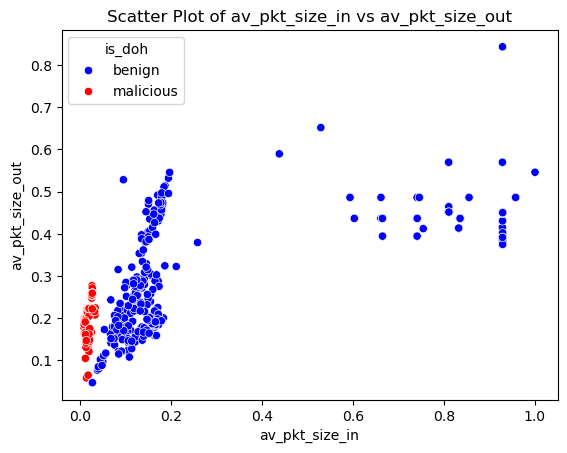

In [16]:
# Assign labels "malicious" and "benign" based on values in 'label_col'
data_vis[label_col][data_vis[label_col] == -1] = "malicious"
data_vis[label_col][data_vis[label_col] == 1] = "benign"

# Create a scatter plot with specified attributes
sns.scatterplot(x='av_pkt_size_in', y='av_pkt_size_out', data=data_vis, marker='o', hue=label_col, palette= {'malicious':'red','benign':'blue' })

# Set labels for the x and y axes
plt.xlabel('av_pkt_size_in')
plt.ylabel('av_pkt_size_out')

# Set the title for the scatter plot
plt.title('Scatter Plot of av_pkt_size_in vs av_pkt_size_out')

# Display the plot
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

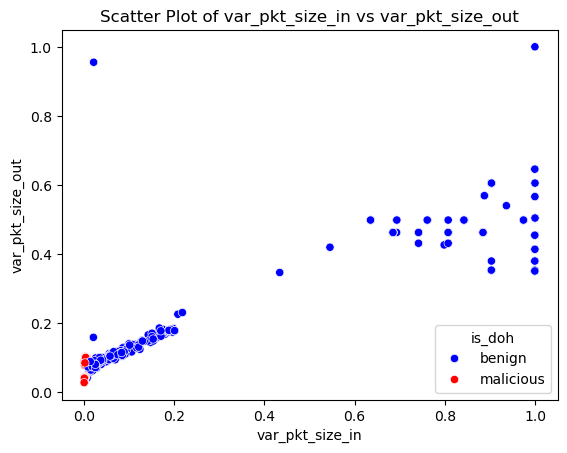

In [17]:
# Assign labels "malicious" and "benign" based on values in 'label_col'
data_vis[label_col][data_vis[label_col] == -1] = "malicious"
data_vis[label_col][data_vis[label_col] == 1] = "benign"

# Create a scatter plot with specified attributes
sns.scatterplot(x='var_pkt_size_in', y='var_pkt_size_out', data=data_vis, marker='o', hue=label_col,  palette= {'malicious':'red','benign':'blue' })

# Set labels for the x and y axes
plt.xlabel('var_pkt_size_in')
plt.ylabel('var_pkt_size_out')

# Set the title for the scatter plot
plt.title('Scatter Plot of var_pkt_size_in vs var_pkt_size_out')

# Display the plot
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

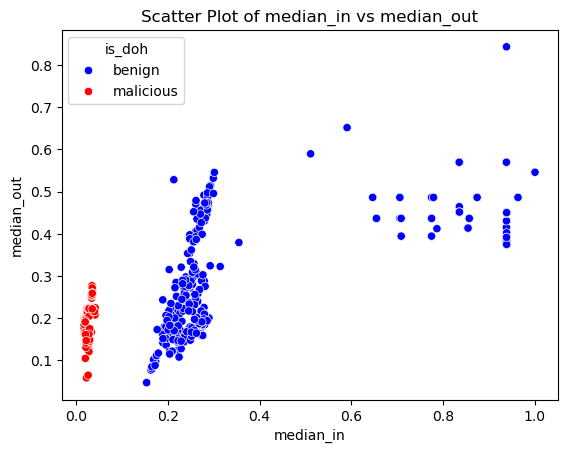

In [18]:
# Assign labels "malicious" and "benign" based on values in 'label_col'
data_vis[label_col][data_vis[label_col] == -1] = "malicious"
data_vis[label_col][data_vis[label_col] == 1] = "benign"

# Create a scatter plot with specified attributes
sns.scatterplot(x='median_in', y='median_out', data=data_vis, marker='o', hue=label_col, palette= {'malicious':'red','benign':'blue' })

# Set labels for the x and y axes
plt.xlabel('median_in')
plt.ylabel('median_out')

# Set the title for the scatter plot
plt.title('Scatter Plot of median_in vs median_out')

# Display the plot
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

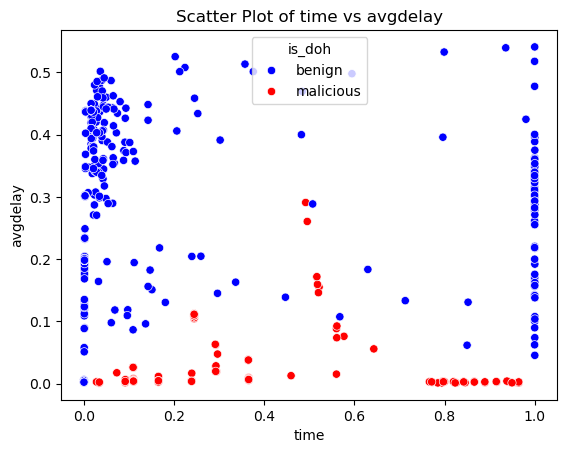

In [19]:
# Assign labels "malicious" and "benign" based on values in 'label_col'
data_vis[label_col][data_vis[label_col] == -1] = "malicious"
data_vis[label_col][data_vis[label_col] == 1] = "benign"

# Create a scatter plot with specified attributes
sns.scatterplot(x='time', y='avgdelay', data=data_vis, marker='o', hue=label_col, palette= {'malicious':'red','benign':'blue' })

# Set labels for the x and y axes
plt.xlabel('time')
plt.ylabel('avgdelay')

# Set the title for the scatter plot
plt.title('Scatter Plot of time vs avgdelay')

# Display the plot
plt.show